In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
from project.utils import compute_statistics
from project.evaluation import isa_vit_metric, Tracker

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
vit_tk = Tracker()

### Monitoring and CUDA Setup


In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Dec_02_2024_214431'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

### Config for RPN and ViT Fitter


In [6]:
from project.model import ISAVIT, Feeder

In [7]:
image_size = 300
patch_size = 32

### Dataset Loading


In [8]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [9]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


In [10]:
vit_tk.only_cmb_slices = True

In [11]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [12]:
feedset = make_feedset(
    data=data,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 50
GLOBAL MIN & MAX (0.0, 87519.8515625)



### Preprocessing and Train-Test Split Function


In [13]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                ):
    
    if cohort == 1:
        vit_tk.cohort1 = True
    if cohort == 2:
        vit_tk.cohort2 = True
    if cohort == 3:
        vit_tk.cohort3 = True

    vit_tk.test_size = test_size
    vit_tk.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

In [14]:
from project import Fitter
from project.preprocessing import get_transform

In [15]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

In [16]:
import torch

In [17]:
feeder = Feeder(resize)

In [18]:
import numpy as np

### ViT Fitter


In [ ]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader)
            val_loss, val_metric = self.validation(val_loader)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        TP = 0
        FP = 0
        FN = 0
        counter = 0
        total_sample = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                bbox = bboxes[target].int().tolist()
                
                x = feeder(slices, bbox, 32)
                t = feeder(masks, bbox, 32)

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)                
                y = self.model(x, target)
                tp, fp, fn = count_fptpfn(y, t[target])

                TP += tp
                FP += fp
                FN += fn
                total_sample += 1

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        dice_score, precision_score, recall_score, f1_score, fp_avg = isa_vit_metric(TP, FP, FN, total_sample)
        evaluation_metric['dice_score'].append(dice_score)
        evaluation_metric['precision_score'].append(precision_score)
        evaluation_metric['recall_score'].append(recall_score)
        evaluation_metric['f1_score'].append(f1_score)
        evaluation_metric['fpr'].append(fp_avg)

        self.log(f'\nTraining Evaluation Metric:')
        self.log(f'Dice: {dice_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1: {f1_score}\nFPavg: {fp_avg}')
        return loss_history, evaluation_metric
    
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        TP = 0
        FP = 0
        FN = 0
        total_sample = 0
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    regions = feedset.locate_case_by_mri(case)
                    bboxes = regions[1].view(regions[1].shape[0], -1)
                    bbox = bboxes[target].int().tolist()
                
                    x = feeder(slices, bbox, 32)
                    t = feeder(masks, bbox, 32)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    tp, fp, fn = count_fptpfn(y, t[target])

                    TP += tp
                    FP += fp
                    FN += fn
                    total_sample += 1
                    Y.append(y)
                    T.append(t[target])
                    
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        
        dice_score, precision_score, recall_score, f1_score, fp_avg = isa_vit_metric(TP, FP, FN, total_sample)
        evaluation_metric['dice_score'].append(dice_score)
        evaluation_metric['precision_score'].append(precision_score)
        evaluation_metric['recall_score'].append(recall_score)
        evaluation_metric['f1_score'].append(f1_score)
        evaluation_metric['fpr'].append(fp_avg)

        self.log(f'\nValidations Evaluation Metric:')
        self.log(f'Dice: {dice_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1: {f1_score}\nFPavg: {fp_avg}')
        return loss_history, evaluation_metric

### Train-Test Split


In [20]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [21]:
from torch.utils.data import ConcatDataset

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x00000206311A8450>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000020631146210>


In [ ]:
batchs = 20
vit_tk.batch_size = batchs

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

In [23]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.33, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs) 
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        true_pos = (inputs * targets).sum()
        false_neg = ((1 - inputs) * targets).sum()
        false_pos = (inputs * (1 - targets)).sum()

        tversky_index = (true_pos + self.smooth) / (
            true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        focal_tversky = (1 - tversky_index) ** self.gamma
        return focal_tversky


In [24]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600,
        global_context=False,
        patchpatch_size=16,
        n_layers=12
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': FocalTverskyLoss(alpha=0.2, beta=0.8, gamma=1.33),
    'lr': 0.0001
}

vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### K-Fold Cross Validation


In [25]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [27]:
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [28]:
rpn_fold_metrics = []
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(vit_train_set)):
    print(f'Fold {i + 1}/{5}')

    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)

    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 20
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

Fold 1/5


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9371014833450317

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9267719388008118

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Curr

Fold 2/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9463515877723694

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9298530220985413

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.9253571629524231

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.13938242012149646
INFO:kess:Avg Precision: 0.0847399696724893
INFO:kess:Avg Recall: 0.556899655316015
INFO:kess:Avg F1: 0.13938242012149646
INFO:kess:Avg FPR: 455.41379310344826

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.16296402234473006
INFO:kess:Avg Precision: 0.10596070995740876
INFO:kess:Avg Recall: 0.6483306534735106
INFO:kess:Avg F1: 0.1629640223447301
INFO:kess:Avg FPR: 436.6666666666667

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9162886738777161

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9375403523445129

Fold 3/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9227712750434875

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9302729368209839

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.9226193428039551

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.14894543999439036
INFO:kess:Avg Precision: 0.09274902048985392
INFO:kess:Avg Recall: 0.5661181599965114
INFO:kess:Avg F1: 0.14894543999439036
INFO:kess:Avg FPR: 477.6551724137931

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.09899993348711258
INFO:kess:Avg Precision: 0.05531517135430568
INFO:kess:Avg Recall: 0.6330261431075846
INFO:kess:Avg F1: 0.09899993348711258
INFO:kess:Avg FPR: 484.8

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.922247588634491

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9317552447319031

INFO:kess

Fold 4/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9324280023574829

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9459356069564819

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.9281337261199951

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.13197311102488035
INFO:kess:Avg Precision: 0.08100154136801693
INFO:kess:Avg Recall: 0.570911266003292
INFO:kess:Avg F1: 0.13197311102488035
INFO:kess:Avg FPR: 478.3728813559322

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.19110126353948517
INFO:kess:Avg Precision: 0.11753921636746566
INFO:kess:Avg Recall: 0.6581611410606261
INFO:kess:Avg F1: 0.19110126353948512
INFO:kess:Avg FPR: 460.92857142857144

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9311791062355042

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.93352615833282

Fold 5/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9468643069267273

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9347163438796997

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.9253836870193481

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.1286174072841113
INFO:kess:Avg Precision: 0.07865950399220699
INFO:kess:Avg Recall: 0.560398441358482
INFO:kess:Avg F1: 0.12861740728411128
INFO:kess:Avg FPR: 485.5762711864407

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.18444998157382628
INFO:kess:Avg Precision: 0.11482809405315576
INFO:kess:Avg Recall: 0.620536953295927
INFO:kess:Avg F1: 0.18444998157382628
INFO:kess:Avg FPR: 451.57142857142856

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.9415477514266968

INFO:kess:Batch:	2/3
INFO:kess:Batch sample

In [29]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def plot_metric_history(fold_metrics, metric, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
            
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label=f'Validation {metric}')
    
    plt.title(f'{title} - Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
        
    plt.tight_layout()  
    plt.show()

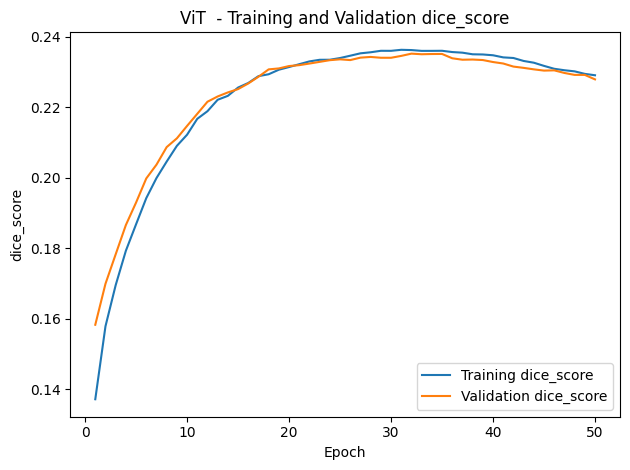

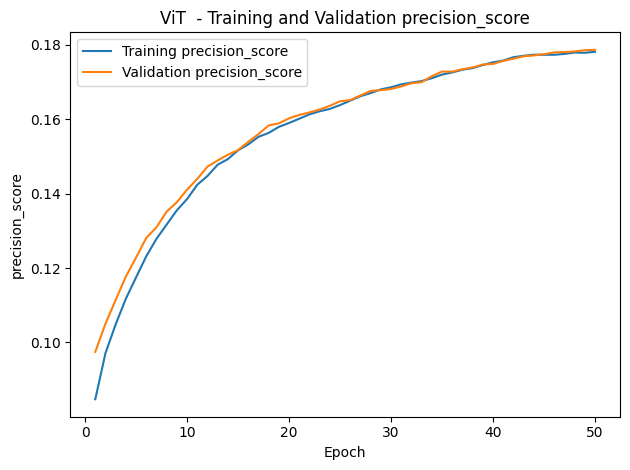

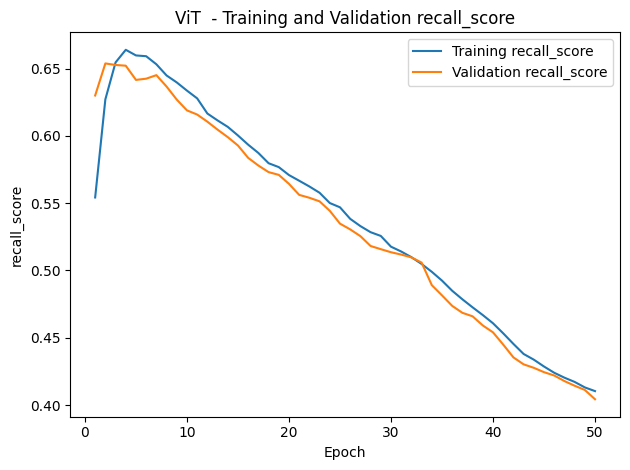

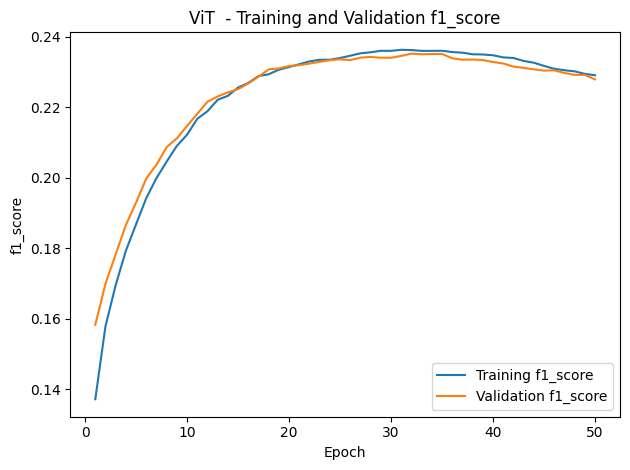

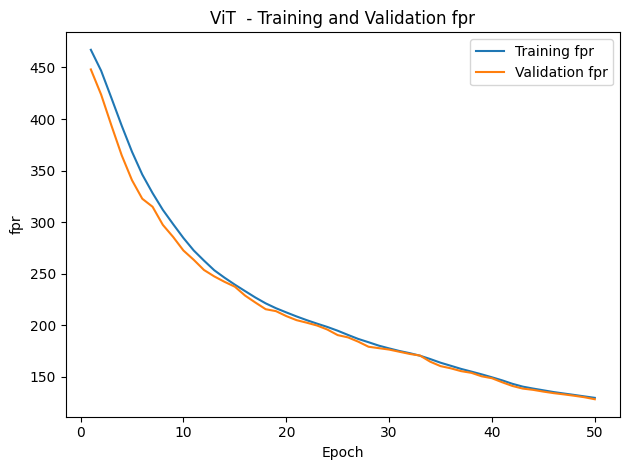

In [32]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [33]:
def plot_loss_history(fold_metrics, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
        
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label='Training history')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label='Validation history')
        
    plt.title(f'{title} - Training and Validation history')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    
    plt.tight_layout()  
    plt.show()

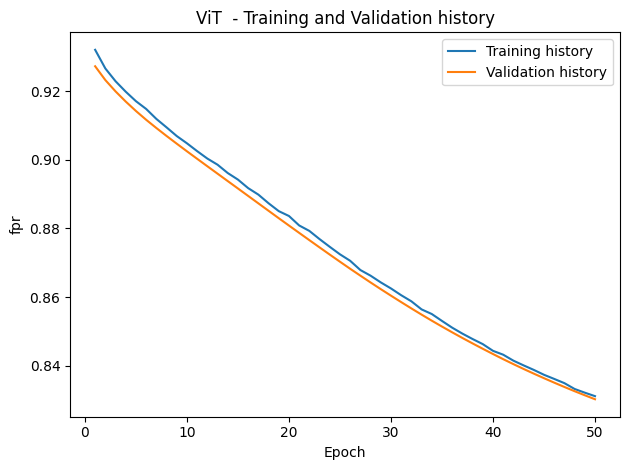

In [34]:
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### ViT


In [35]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [36]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [37]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [38]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.254033,0.194408,0.428279,0.254033,128.894737
1,2,0.252357,0.196330,0.411662,0.252357,122.157895
2,3,0.256246,0.193296,0.445531,0.256246,135.526316
3,4,0.252444,0.196330,0.412122,0.252444,122.157895
4,5,0.249669,0.195946,0.400355,0.249669,119.000000


In [39]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.25294983068813043 
Average Precision: 0.19526177196191047 
Average Recall: 0.4195896307513137 
Average F1 Score: 0.2529498306881305 
Average FPR: 125.54736842105262 


In [40]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

In [41]:
df_vit_metrics.to_csv(f'./statistical-treatment/perfect-bbox-vanilla-vit.csv')

### Sample


#### ViT


In [42]:
import matplotlib.patches as patches

C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_25184\3201991568.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, a = plt.subplots(1, 2, figsize=(10, 4))


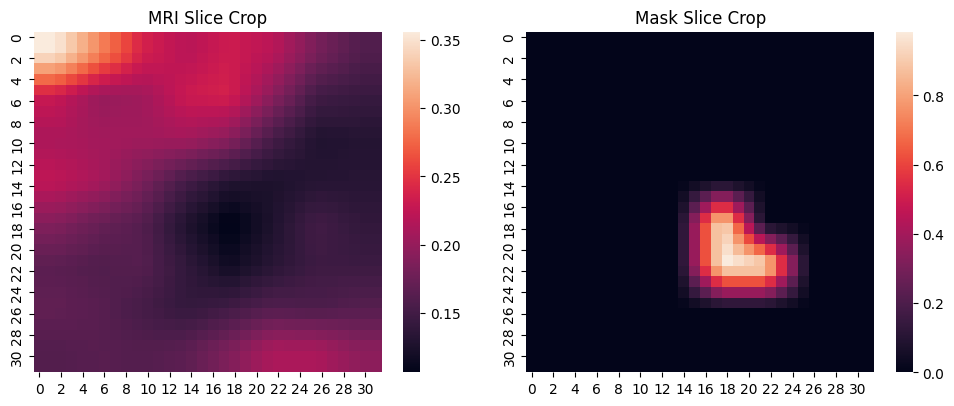

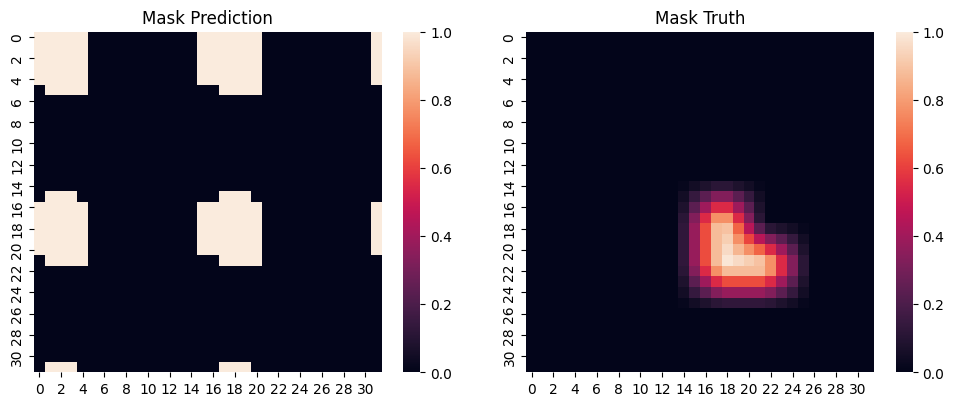

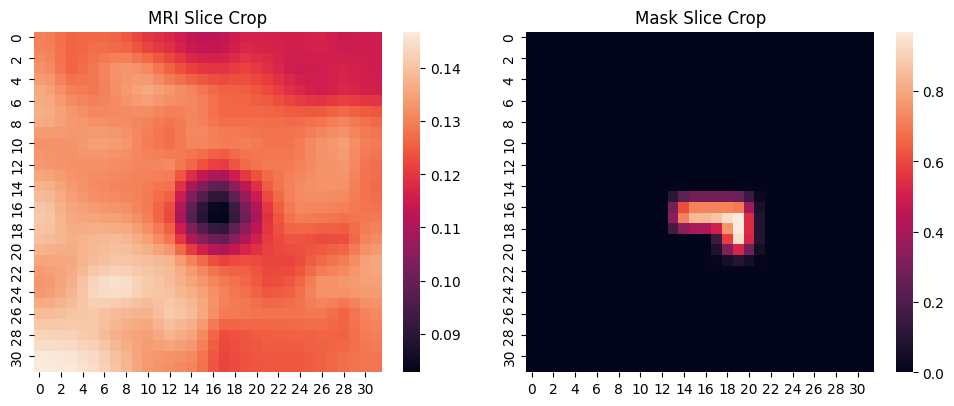

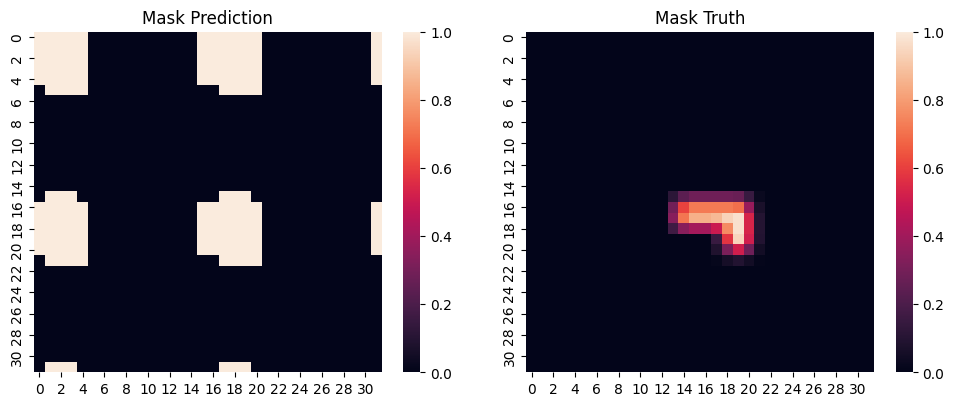

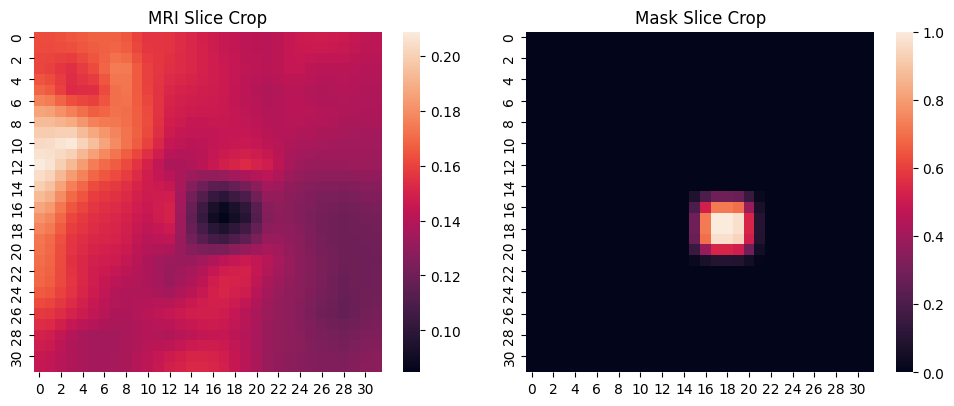

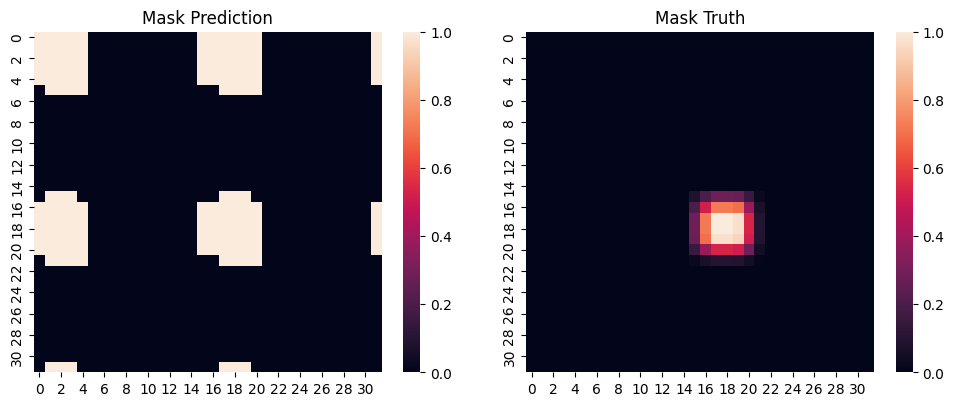

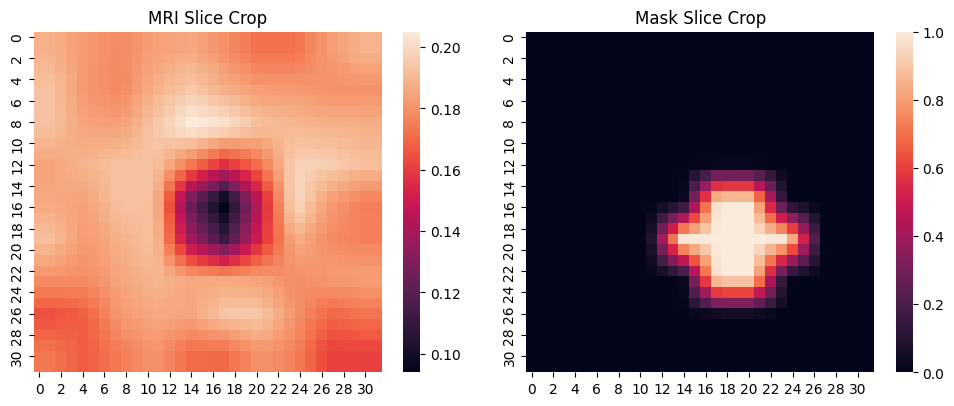

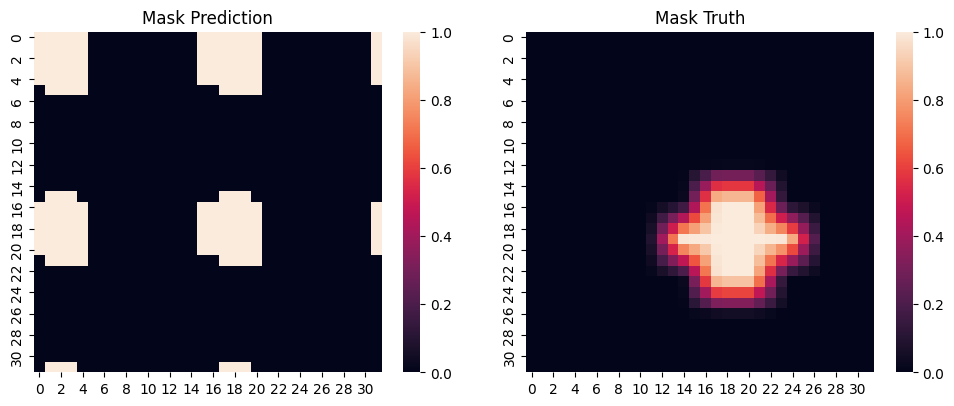

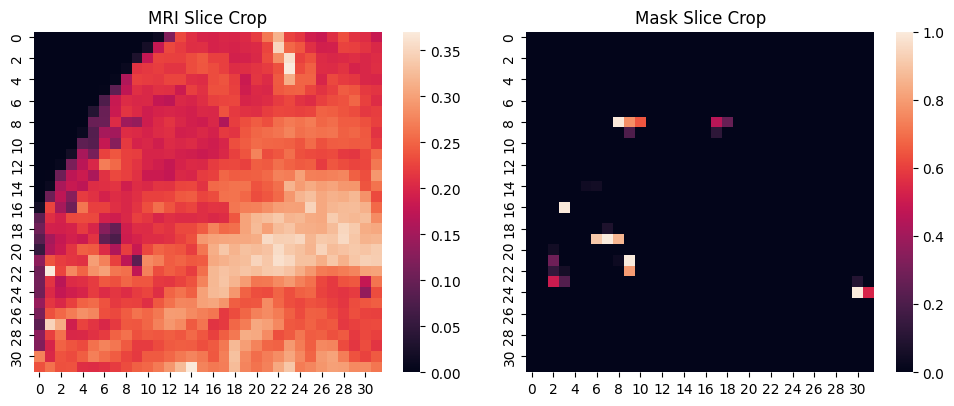

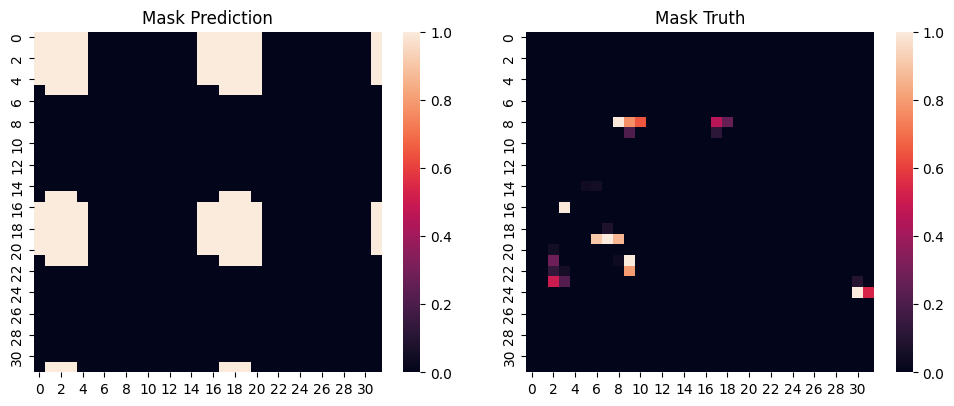

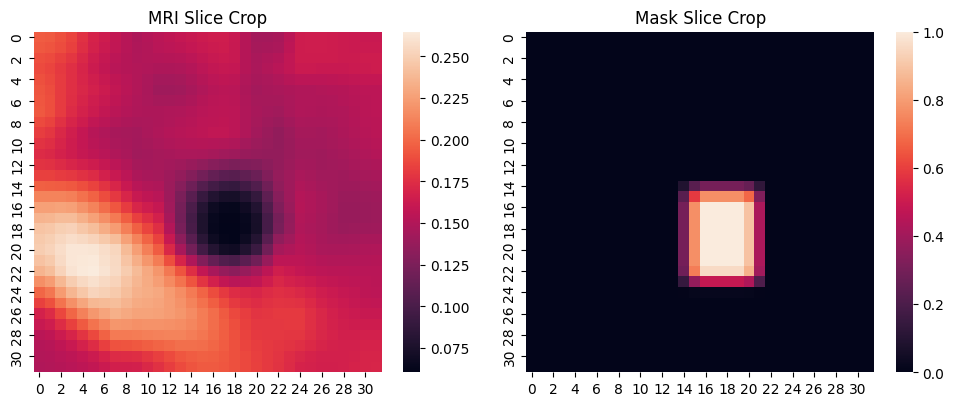

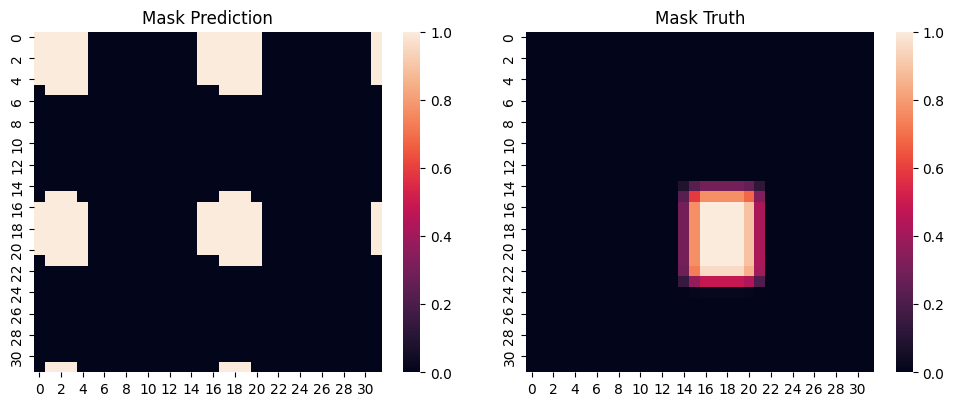

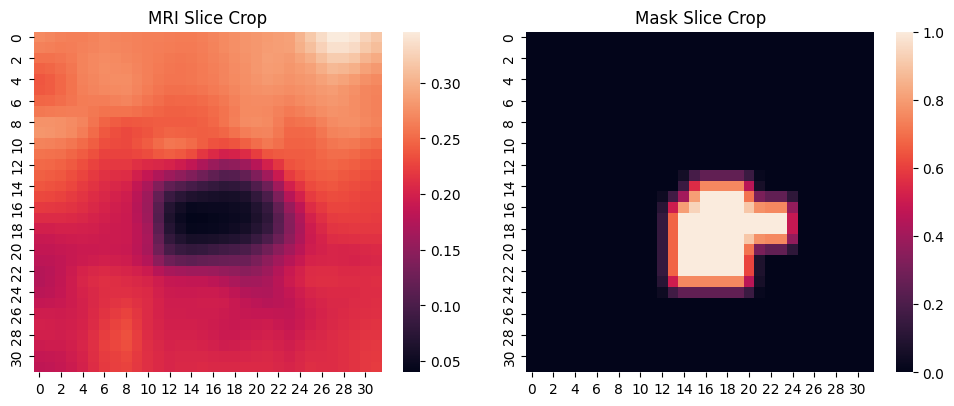

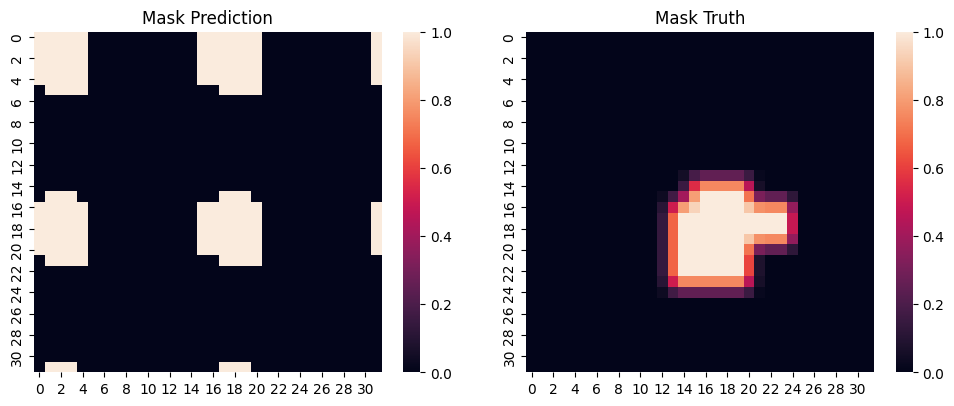

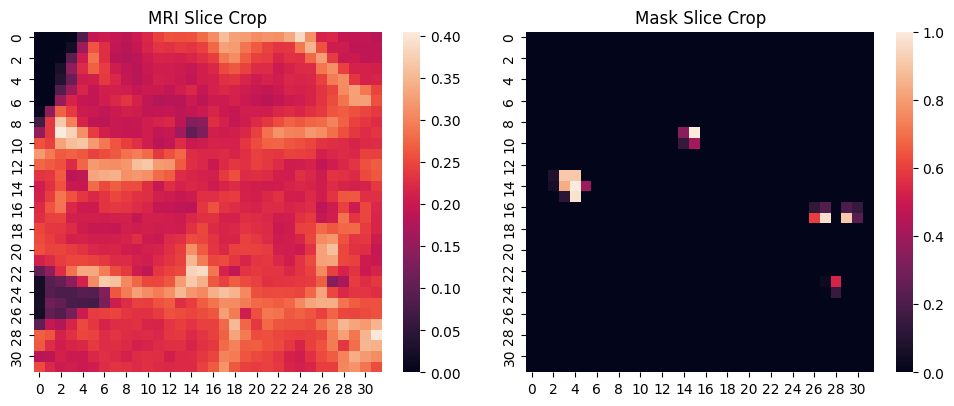

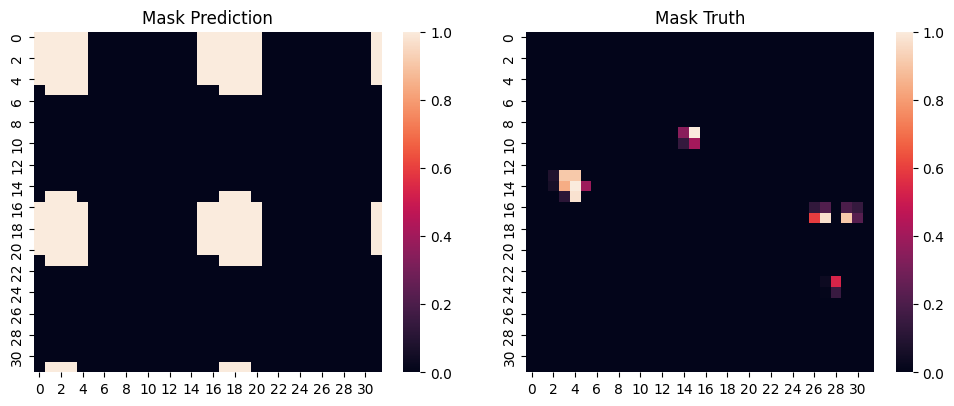

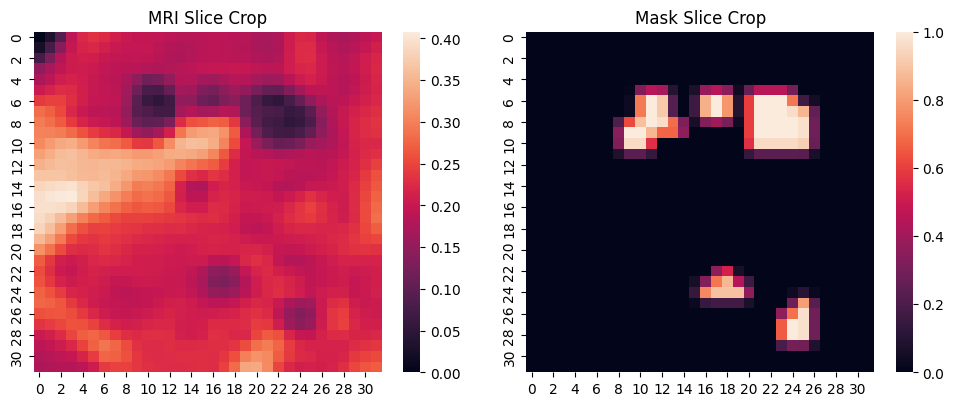

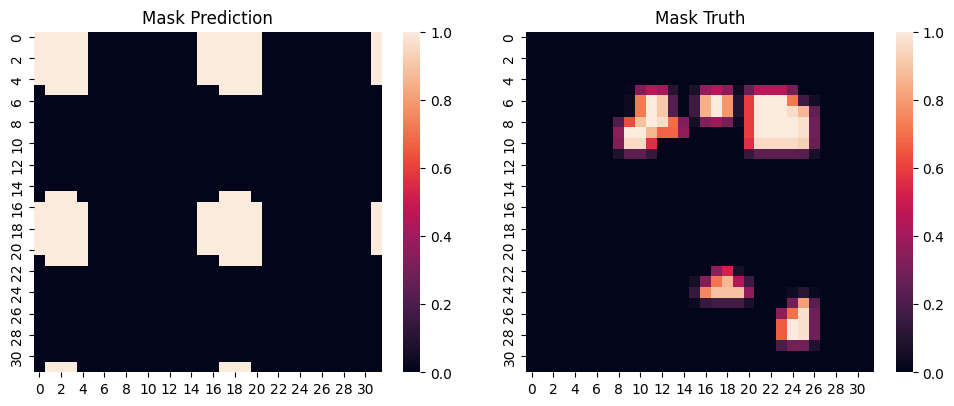

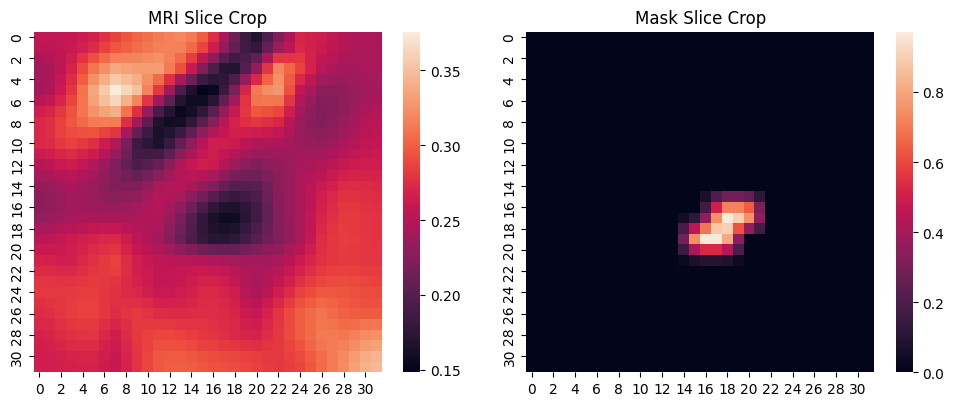

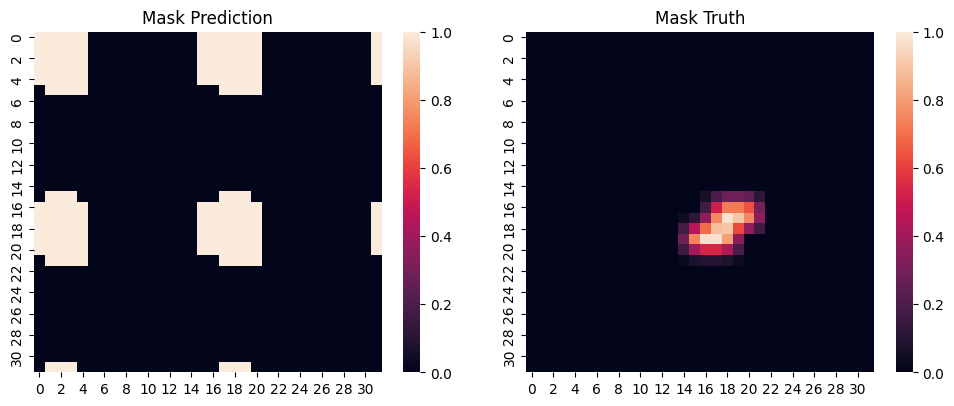

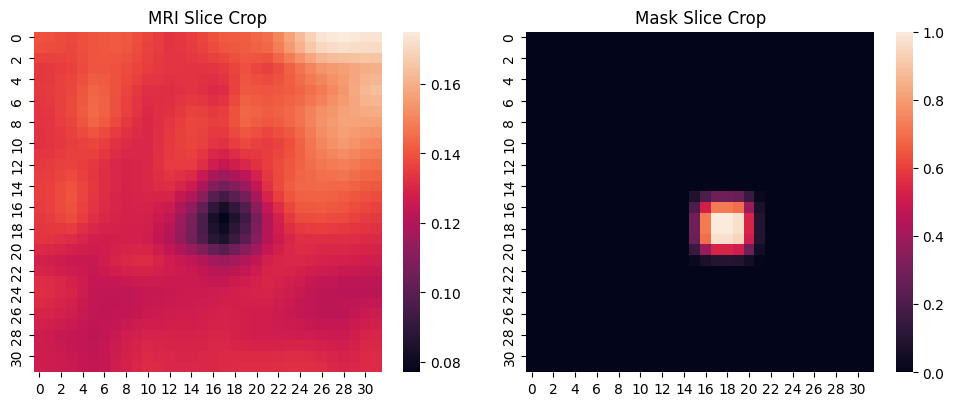

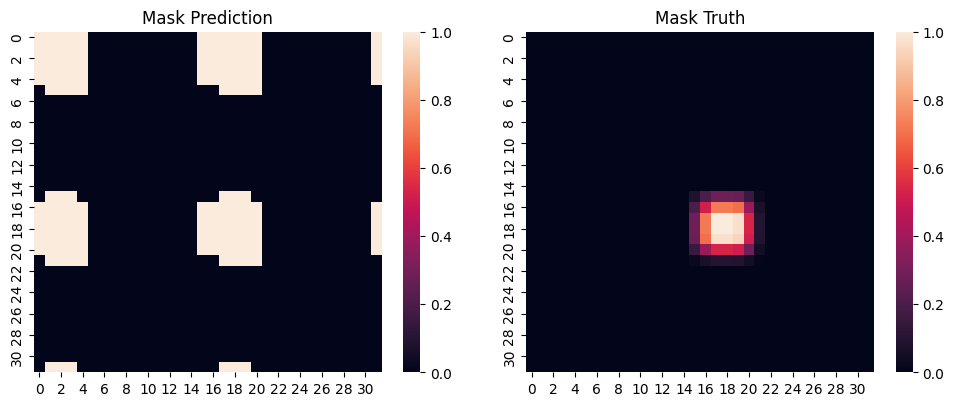

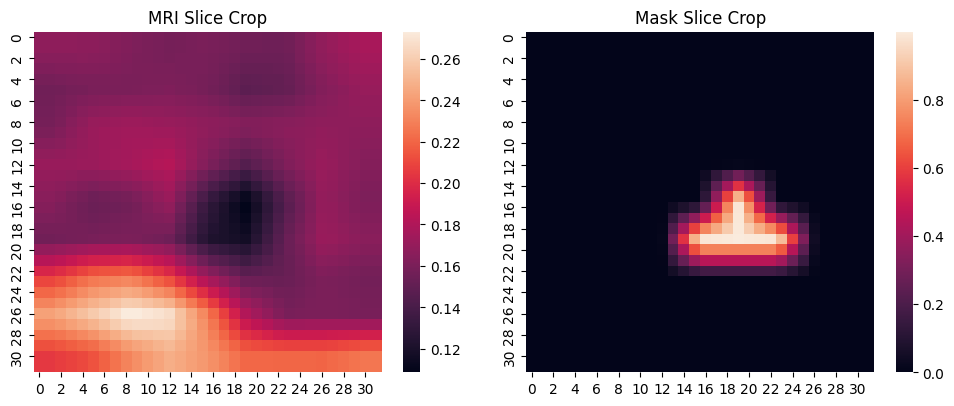

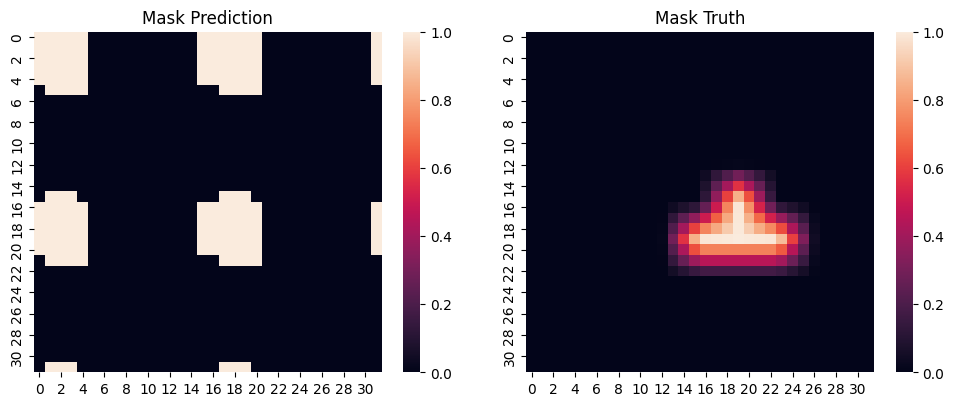

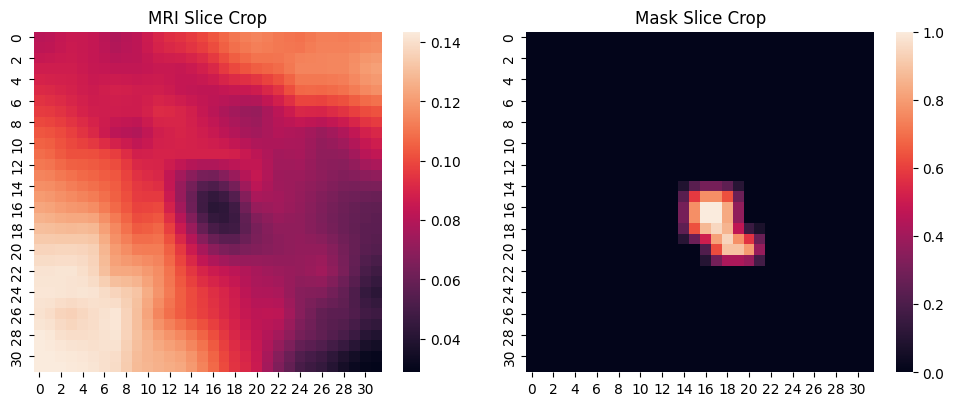

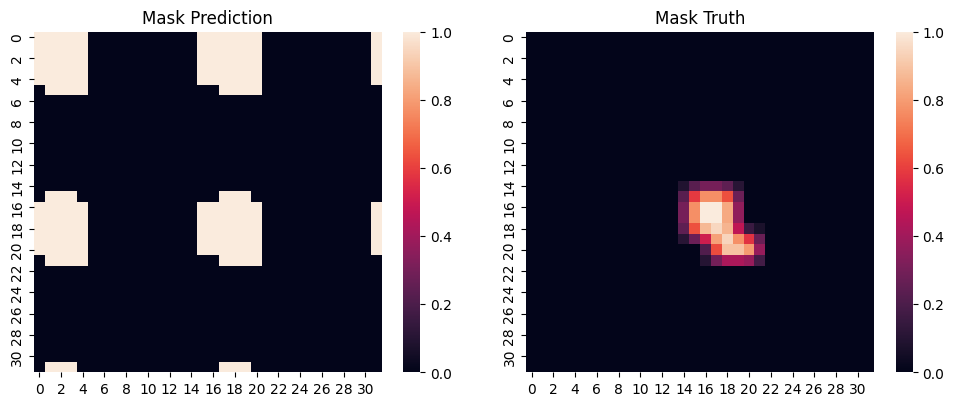

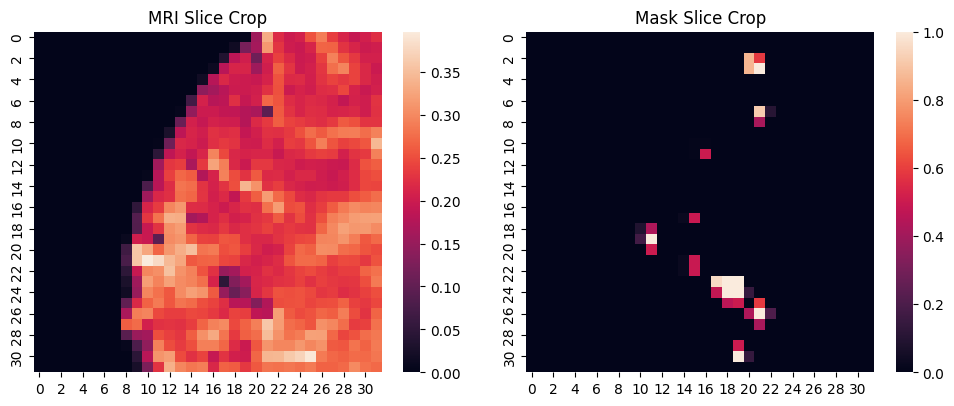

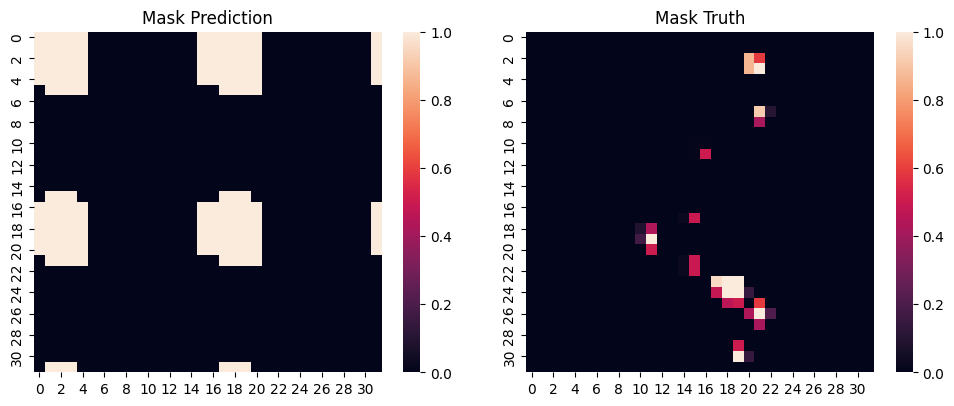

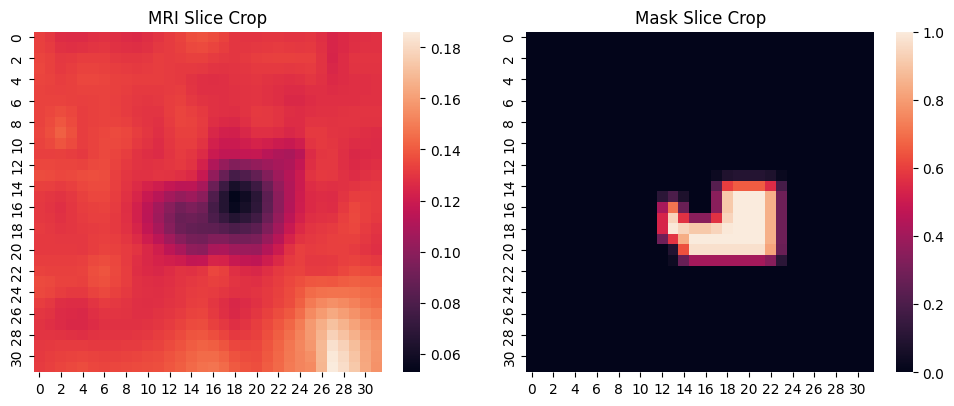

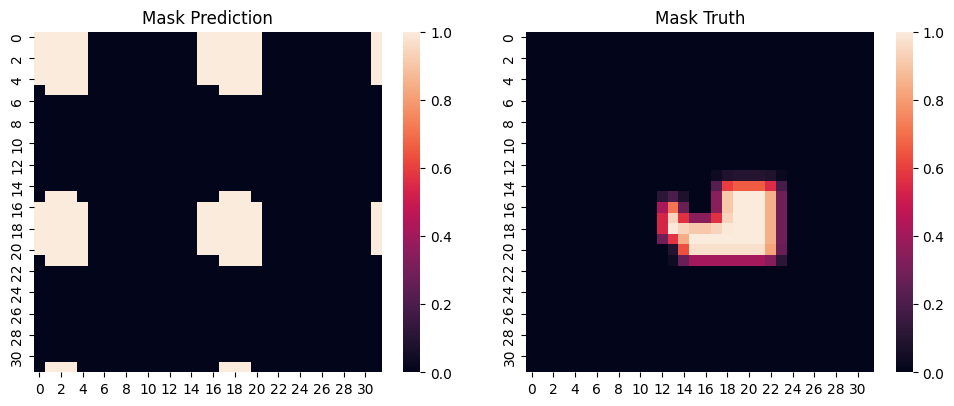

In [43]:
sample = next(iter(vit_test_dataloader))

for i in range(len(next(iter(vit_test_dataloader)))):
    vit_slices, vit_masks, vit_target, vit_case = sample[i]
    
    vit_slices = vit_slices.squeeze(1).float().to(device)
    vit_masks = vit_masks.float().to(device)
    
    regions = feedset.locate_case_by_mri(vit_case)
    bboxes = regions[1].view(regions[1].shape[0], -1)
    bbox = bboxes[vit_target].int().tolist()
                    
    vit_x = feeder(vit_slices, bbox, 16)
    vit_t = feeder(vit_masks, bbox, 16)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('MRI Slice Crop')
    ax2.set_title('Mask Slice Crop')
    sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
    sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

    vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
    vit_y = vit_y.view(patch_size, patch_size)
    vit_y = torch.sigmoid(vit_y)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('Mask Prediction')
    ax2.set_title('Mask Truth')
    sns.heatmap((vit_y > 0.5).detach().cpu(), ax=ax1, vmax=1)
    sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

# Log Progress


In [44]:
vit_tk.notes = '''
no global context
'''

In [45]:
vit_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-12-02 21:44:31.108796,ViT,None,None,None,True,True,False,True,<class 'torch.optim.adam.Adam'>,50,...,0 0.428279 1 0.411662 2 0.445531 3 ...,0 0.254033 1 0.252357 2 0.256246 3 ...,0 128.894737 1 122.157895 2 135.52631...,None,None,None,"{'d_model': 512, 'patch_size': 32, 'dim_ff': 1...",rpn_vit_Dec_02_2024_214431.log,cuda,\nno global context\n


In [46]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    vit_tk().to_csv('history/runs.csv')

Merging to old df


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_25184\3886131270.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, vit_tk()])
